In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import scipy

%matplotlib inline

from scipy import misc
import os
from os import listdir
from os.path import isfile, join
import shutil
import stat
import collections
from collections import defaultdict

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

import h5py
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.applications.inception_v3 import preprocess_input
from keras.models import load_model

Using TensorFlow backend.


In [2]:
class_to_ix = {}
ix_to_class = {}
with open('food-101/meta/classes.txt', 'r') as txt:
    classes = [l.strip() for l in txt.readlines()]
    class_to_ix = dict(zip(classes, range(len(classes))))
    ix_to_class = dict(zip(range(len(classes)), classes))
    class_to_ix = {v: k for k, v in ix_to_class.items()}
sorted_class_to_ix = collections.OrderedDict(sorted(class_to_ix.items()))

In [3]:
%%time
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load dataset images and resize to meet minimum width and height pixel size
def load_images(root, min_side=299):
    all_imgs = []
    all_classes = []
    resize_count = 0
    invalid_count = 0
    for i, subdir in enumerate(listdir(root)):
        imgs = listdir(join(root, subdir))
        class_ix = class_to_ix[subdir]
        print(i, class_ix, subdir)
        for img_name in imgs:
            img_arr = img.imread(join(root, subdir, img_name))
            
            img_arr_rs = img_arr
            try:
                w, h, _ = img_arr.shape
                if w < min_side:
                    wpercent = (min_side/float(w))
                    hsize = int((float(h)*float(wpercent)))
                    print('new dims:', min_side, hsize)
                    img_arr_rs = imresize(img_arr, (min_side, hsize))
                    resize_count += 1
                elif h < min_side:
                    hpercent = (min_side/float(h))
                    wsize = int((float(w)*float(hpercent)))
                    print('new dims:', wsize, min_side)
                    img_arr_rs = imresize(img_arr, (wsize, min_side))
                    resize_count += 1
                all_imgs.append(img_arr_rs)
                all_classes.append(class_ix)
            except:
                print('Skipping bad image: ', subdir, img_name)
                invalid_count += 1
    print(len(all_imgs), 'images loaded')
    print(resize_count, 'images resized')
    print(invalid_count, 'images skipped')
    return np.array(all_imgs), np.array(all_classes)
    
X_test, y_test = load_images('test', min_side=299)

0 0 apple_pie
new dims: 299 529
Skipping bad image:  apple_pie 2523928.jpg
new dims: 299 529
Skipping bad image:  apple_pie 2791334.jpg
new dims: 299 531
Skipping bad image:  apple_pie 3635782.jpg
new dims: 531 299
Skipping bad image:  apple_pie 829830.jpg
new dims: 299 529
Skipping bad image:  apple_pie 861244.jpg
1 1 baby_back_ribs
new dims: 299 533
Skipping bad image:  baby_back_ribs 1221409.jpg
new dims: 299 531
Skipping bad image:  baby_back_ribs 18596.jpg
new dims: 299 529
Skipping bad image:  baby_back_ribs 1907138.jpg
new dims: 299 531
Skipping bad image:  baby_back_ribs 2042437.jpg
new dims: 299 533
Skipping bad image:  baby_back_ribs 611849.jpg
2 2 baklava
new dims: 299 531
Skipping bad image:  baklava 2313082.jpg
new dims: 299 533
Skipping bad image:  baklava 2447796.jpg
new dims: 529 299
Skipping bad image:  baklava 2662831.jpg
new dims: 299 529
Skipping bad image:  baklava 3078639.jpg
new dims: 299 531
Skipping bad image:  baklava 3368791.jpg
new dims: 299 529
Skipping bad

new dims: 299 531
Skipping bad image:  cheese_plate 3591759.jpg
new dims: 299 531
Skipping bad image:  cheese_plate 3660496.jpg
new dims: 299 531
Skipping bad image:  cheese_plate 38026.jpg
new dims: 299 531
Skipping bad image:  cheese_plate 927349.jpg
new dims: 529 299
Skipping bad image:  cheese_plate 940584.jpg
18 18 chicken_curry
new dims: 299 533
Skipping bad image:  chicken_curry 1536664.jpg
new dims: 529 299
Skipping bad image:  chicken_curry 1574275.jpg
new dims: 299 531
Skipping bad image:  chicken_curry 3506313.jpg
new dims: 299 529
Skipping bad image:  chicken_curry 3583694.jpg
new dims: 299 533
Skipping bad image:  chicken_curry 473888.jpg
new dims: 529 299
Skipping bad image:  chicken_curry 740269.jpg
new dims: 299 531
Skipping bad image:  chicken_curry 894681.jpg
19 19 chicken_quesadilla
new dims: 299 533
Skipping bad image:  chicken_quesadilla 1052529.jpg
new dims: 299 533
Skipping bad image:  chicken_quesadilla 1238682.jpg
new dims: 299 529
Skipping bad image:  chicken_

new dims: 531 299
Skipping bad image:  falafel 2117115.jpg
new dims: 299 531
Skipping bad image:  falafel 2145586.jpg
new dims: 299 531
Skipping bad image:  falafel 2378814.jpg
new dims: 533 299
Skipping bad image:  falafel 2608463.jpg
new dims: 299 531
Skipping bad image:  falafel 3181929.jpg
new dims: 299 529
Skipping bad image:  falafel 781945.jpg
37 37 filet_mignon
new dims: 299 529
Skipping bad image:  filet_mignon 1486568.jpg
new dims: 299 529
Skipping bad image:  filet_mignon 1655544.jpg
new dims: 299 533
Skipping bad image:  filet_mignon 2507921.jpg
new dims: 531 299
Skipping bad image:  filet_mignon 2654995.jpg
new dims: 299 529
Skipping bad image:  filet_mignon 3073781.jpg
new dims: 299 533
Skipping bad image:  filet_mignon 384251.jpg
new dims: 299 529
Skipping bad image:  filet_mignon 3860923.jpg
38 38 fish_and_chips
new dims: 299 529
Skipping bad image:  fish_and_chips 1961695.jpg
new dims: 299 529
Skipping bad image:  fish_and_chips 2503977.jpg
new dims: 299 529
Skipping b

56 56 huevos_rancheros
new dims: 299 554
Skipping bad image:  huevos_rancheros 1228280.jpg
new dims: 299 533
Skipping bad image:  huevos_rancheros 1254396.jpg
new dims: 299 529
Skipping bad image:  huevos_rancheros 2317990.jpg
new dims: 299 529
Skipping bad image:  huevos_rancheros 2412003.jpg
new dims: 533 299
Skipping bad image:  huevos_rancheros 519751.jpg
new dims: 299 529
Skipping bad image:  huevos_rancheros 898352.jpg
57 57 hummus
new dims: 299 529
Skipping bad image:  hummus 176221.jpg
new dims: 299 531
Skipping bad image:  hummus 1933615.jpg
new dims: 299 529
Skipping bad image:  hummus 263106.jpg
new dims: 531 299
Skipping bad image:  hummus 288902.jpg
new dims: 529 299
Skipping bad image:  hummus 3118194.jpg
new dims: 299 531
Skipping bad image:  hummus 3710171.jpg
new dims: 531 299
Skipping bad image:  hummus 3876722.jpg
new dims: 299 531
Skipping bad image:  hummus 861994.jpg
58 58 ice_cream
new dims: 529 299
Skipping bad image:  ice_cream 2221588.jpg
new dims: 299 533
Ski

new dims: 299 602
Skipping bad image:  peking_duck 548149.jpg
new dims: 299 529
Skipping bad image:  peking_duck 886593.jpg
75 75 pho
new dims: 299 529
Skipping bad image:  pho 1028507.jpg
new dims: 299 529
Skipping bad image:  pho 1337076.jpg
new dims: 299 529
Skipping bad image:  pho 2234433.jpg
new dims: 299 529
Skipping bad image:  pho 3873024.jpg
new dims: 299 533
Skipping bad image:  pho 395877.jpg
new dims: 299 531
Skipping bad image:  pho 881249.jpg
new dims: 529 299
Skipping bad image:  pho 929667.jpg
76 76 pizza
new dims: 299 529
Skipping bad image:  pizza 1980749.jpg
new dims: 529 299
Skipping bad image:  pizza 2827154.jpg
new dims: 299 531
Skipping bad image:  pizza 3442426.jpg
new dims: 299 529
Skipping bad image:  pizza 457350.jpg
77 77 pork_chop
new dims: 299 529
Skipping bad image:  pork_chop 1471513.jpg
new dims: 531 299
Skipping bad image:  pork_chop 1541477.jpg
new dims: 299 531
Skipping bad image:  pork_chop 2968434.jpg
new dims: 299 531
Skipping bad image:  pork_ch

new dims: 299 531
Skipping bad image:  spring_rolls 405925.jpg
93 93 steak
new dims: 529 299
Skipping bad image:  steak 1194662.jpg
new dims: 531 299
Skipping bad image:  steak 1288129.jpg
new dims: 529 299
Skipping bad image:  steak 2144308.jpg
new dims: 533 299
Skipping bad image:  steak 2738323.jpg
new dims: 299 531
Skipping bad image:  steak 2814314.jpg
new dims: 299 531
Skipping bad image:  steak 3504515.jpg
new dims: 299 529
Skipping bad image:  steak 3662612.jpg
new dims: 299 531
Skipping bad image:  steak 562855.jpg
94 94 strawberry_shortcake
new dims: 299 529
Skipping bad image:  strawberry_shortcake 1195849.jpg
new dims: 533 299
Skipping bad image:  strawberry_shortcake 154016.jpg
new dims: 299 529
Skipping bad image:  strawberry_shortcake 1773115.jpg
new dims: 299 529
Skipping bad image:  strawberry_shortcake 2180003.jpg
new dims: 299 533
Skipping bad image:  strawberry_shortcake 2537353.jpg
new dims: 531 299
Skipping bad image:  strawberry_shortcake 3116874.jpg
95 95 sushi


In [4]:
%%time
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, ReduceLROnPlateau
from keras.optimizers import SGD
from keras.regularizers import l2
import keras.backend as K
import math

Wall time: 0 ns


In [9]:
%%time
#model = load_model(filepath='./model4.29-0.69.hdf5') 
modelInception = load_model('./model4.18-0.19.hdf5') 

Wall time: 24.7 s


Top-1 Predicted: [32 32 32 32 32 32 32 32 32 32]
Top-5 Predicted: [[83  7 29 32 97]
 [83  7 29 32 97]
 [83 97 29  7 32]
 [83  7 29 97 32]
 [83  7 97 29 32]
 [83  7 97 32 29]
 [83 97 29 32  7]
 [83  7 29 32 97]
 [83  7 29 97 32]
 [83  7 97 29 32]]
True Label: 53


(array([32, 32, 32, 32, 32, 32, 32, 32, 32, 32], dtype=int64),
 array([[83,  7, 29, 32, 97],
        [83,  7, 29, 32, 97],
        [83, 97, 29,  7, 32],
        [83,  7, 29, 97, 32],
        [83,  7, 97, 29, 32],
        [83,  7, 97, 32, 29],
        [83, 97, 29, 32,  7],
        [83,  7, 29, 32, 97],
        [83,  7, 29, 97, 32],
        [83,  7, 97, 29, 32]], dtype=int64))

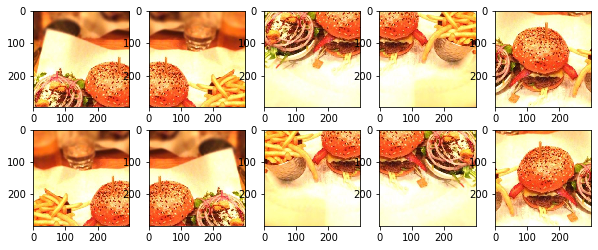

In [11]:
def center_crop(x, center_crop_size, **kwargs):
    centerw, centerh = x.shape[0]//2, x.shape[1]//2
    halfw, halfh = center_crop_size[0]//2, center_crop_size[1]//2
    return x[centerw-halfw:centerw+halfw+1,centerh-halfh:centerh+halfh+1, :]
def predict_10_crop(img, ix, top_n=5, plot=False, preprocess=True, debug=False):
    flipped_X = np.fliplr(img)
    crops = [
        img[:299,:299, :], # Upper Left
        img[:299, img.shape[1]-299:, :], # Upper Right
        img[img.shape[0]-299:, :299, :], # Lower Left
        img[img.shape[0]-299:, img.shape[1]-299:, :], # Lower Right
        center_crop(img, (299, 299)),
        
        flipped_X[:299,:299, :],
        flipped_X[:299, flipped_X.shape[1]-299:, :],
        flipped_X[flipped_X.shape[0]-299:, :299, :],
        flipped_X[flipped_X.shape[0]-299:, flipped_X.shape[1]-299:, :],
        center_crop(flipped_X, (299, 299))
    ]
    if preprocess:
        crops = [preprocess_input(x.astype('float32')) for x in crops]

    if plot:
        fig, ax = plt.subplots(2, 5, figsize=(10, 4))
        ax[0][0].imshow(crops[0])
        ax[0][1].imshow(crops[1])
        ax[0][2].imshow(crops[2])
        ax[0][3].imshow(crops[3])
        ax[0][4].imshow(crops[4])
        ax[1][0].imshow(crops[5])
        ax[1][1].imshow(crops[6])
        ax[1][2].imshow(crops[7])
        ax[1][3].imshow(crops[8])
        ax[1][4].imshow(crops[9])
    
    y_pred = modelInception.predict(np.array(crops))
    preds = np.argmax(y_pred, axis=1)
    top_n_preds= np.argpartition(y_pred, -top_n)[:,-top_n:]
    if debug:
        print('Top-1 Predicted:', preds)
        print('Top-5 Predicted:', top_n_preds)
        print('True Label:', y_test[ix])
    return preds, top_n_preds

    
ix = 13001
predict_10_crop(X_test[ix], ix, top_n=5, plot=True, preprocess=False, debug=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Top-1 Predicted: [53 53 53 53 53 53 53 53 53 53]
Top-5 Predicted: [[37  5 99 80 53]
 [ 4 22 99 80 53]
 [ 4 26  5 53 80]
 [25 37 53 80 93]
 [34 74 53 80 25]
 [61 80 53 99 22]
 [74 99  5 80 53]
 [37 61 80 25 53]
 [74 53 80  5  4]
 [28 80 74 53 25]]
True Label: 53


(array([53, 53, 53, 53, 53, 53, 53, 53, 53, 53], dtype=int64),
 array([[37,  5, 99, 80, 53],
        [ 4, 22, 99, 80, 53],
        [ 4, 26,  5, 53, 80],
        [25, 37, 53, 80, 93],
        [34, 74, 53, 80, 25],
        [61, 80, 53, 99, 22],
        [74, 99,  5, 80, 53],
        [37, 61, 80, 25, 53],
        [74, 53, 80,  5,  4],
        [28, 80, 74, 53, 25]], dtype=int64))

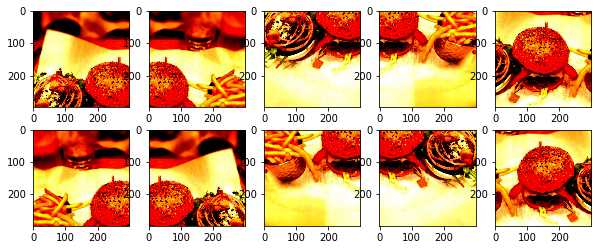

In [12]:
ix = 13001
predict_10_crop(X_test[ix], ix, top_n=5, plot=True, preprocess=True, debug=True)

In [13]:
%%time
preds_10_crop = {}
for ix in range(len(X_test)):
    if ix % 1000 == 0:
        print(ix)
    preds_10_crop[ix] = predict_10_crop(X_test[ix], ix)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
Wall time: 28min 30s


Text(0.5, 1.0, 'Number of unique predictions per image')

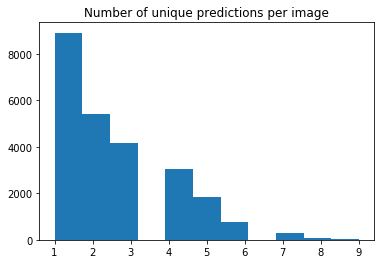

In [14]:
preds_uniq = {k: np.unique(v[0]) for k, v in preds_10_crop.items()}
preds_hist = np.array([len(x) for x in preds_uniq.values()])

plt.hist(preds_hist, bins=11)
plt.title('Number of unique predictions per image')

In [16]:
%%time
preds_top_1 = {k: collections.Counter(v[0]).most_common(1) for k, v in preds_10_crop.items()}

top_5_per_ix = {k: collections.Counter(preds_10_crop[k][1].reshape(-1)).most_common(5) 
                for k, v in preds_10_crop.items()}
preds_top_5 = {k: [y[0] for y in v] for k, v in top_5_per_ix.items()}

right_counter = 0
for i in range(len(y_test)):
    guess, actual = preds_top_1[i][0][0], y_test[i]
    if guess == actual:
        right_counter += 1
        
print('Top-1 Accuracy, 10-Crop: {0:.2f}%'.format(right_counter / len(y_test) * 100))

Top-1 Accuracy, 10-Crop: 76.11%
Wall time: 866 ms


In [17]:
%%time
top_5_counter = 0
for i in range(len(y_test)):
    guesses, actual = preds_top_5[i], y_test[i]
    if actual in guesses:
        top_5_counter += 1
        
print('Top-5 Accuracy, 10-Crop: {0:.2f}%'.format(top_5_counter / len(y_test) * 100))

Top-5 Accuracy, 10-Crop: 92.06%
Wall time: 67.8 ms


In [18]:
y_pred = [x[0][0] for x in preds_top_1.values()]
@interact(page=[0, int(len(X_test)/20)])
def show_images_prediction(page=0):
    page_size = 20
    nrows = 4
    ncols = 5
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12))
    fig.set_size_inches(12, 8)
    #fig.tight_layout()
    #imgs = np.random.choice((y_all == n_class).nonzero()[0], nrows * ncols)
    start_i = page * page_size
    for i, ax in enumerate(axes.flat):
        im = ax.imshow(X_test[i+start_i])
        ax.set_axis_off()
        ax.title.set_visible(False)
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)
        predicted = ix_to_class[y_pred[i+start_i]]
        match = predicted ==  ix_to_class[y_test[start_i + i]]
        ec = (1, .5, .5)
        fc = (1, .8, .8)
        if match:
            ec = (0, .6, .1)
            fc = (0, .7, .2)
        # predicted label
        ax.text(0, 400, 'P: ' + predicted, size=10, rotation=0,
            ha="left", va="top",
             bbox=dict(boxstyle="round",
                   ec=ec,
                   fc=fc,
                   )
             )
        if not match:
            # true label
            ax.text(0, 480, 'A: ' + ix_to_class[y_test[start_i + i]], size=10, rotation=0,
                ha="left", va="top",
                 bbox=dict(boxstyle="round",
                       ec=ec,
                       fc=fc,
                       )
                 )
    plt.subplots_adjust(left=0, wspace=1, hspace=0)
    plt.show()

interactive(children=(Dropdown(description='page', options=(0, 1227), value=0), Output()), _dom_classes=('widg…

Confusion matrix, without normalization
[[139   2   3 ...   3   0   5]
 [  0 166   0 ...   2   0   0]
 [  4   0 218 ...   2   0   1]
 ...
 [  1   0   1 ... 206   0   0]
 [  0   1   0 ...   0 129   0]
 [  0   0   0 ...   0   0 214]]


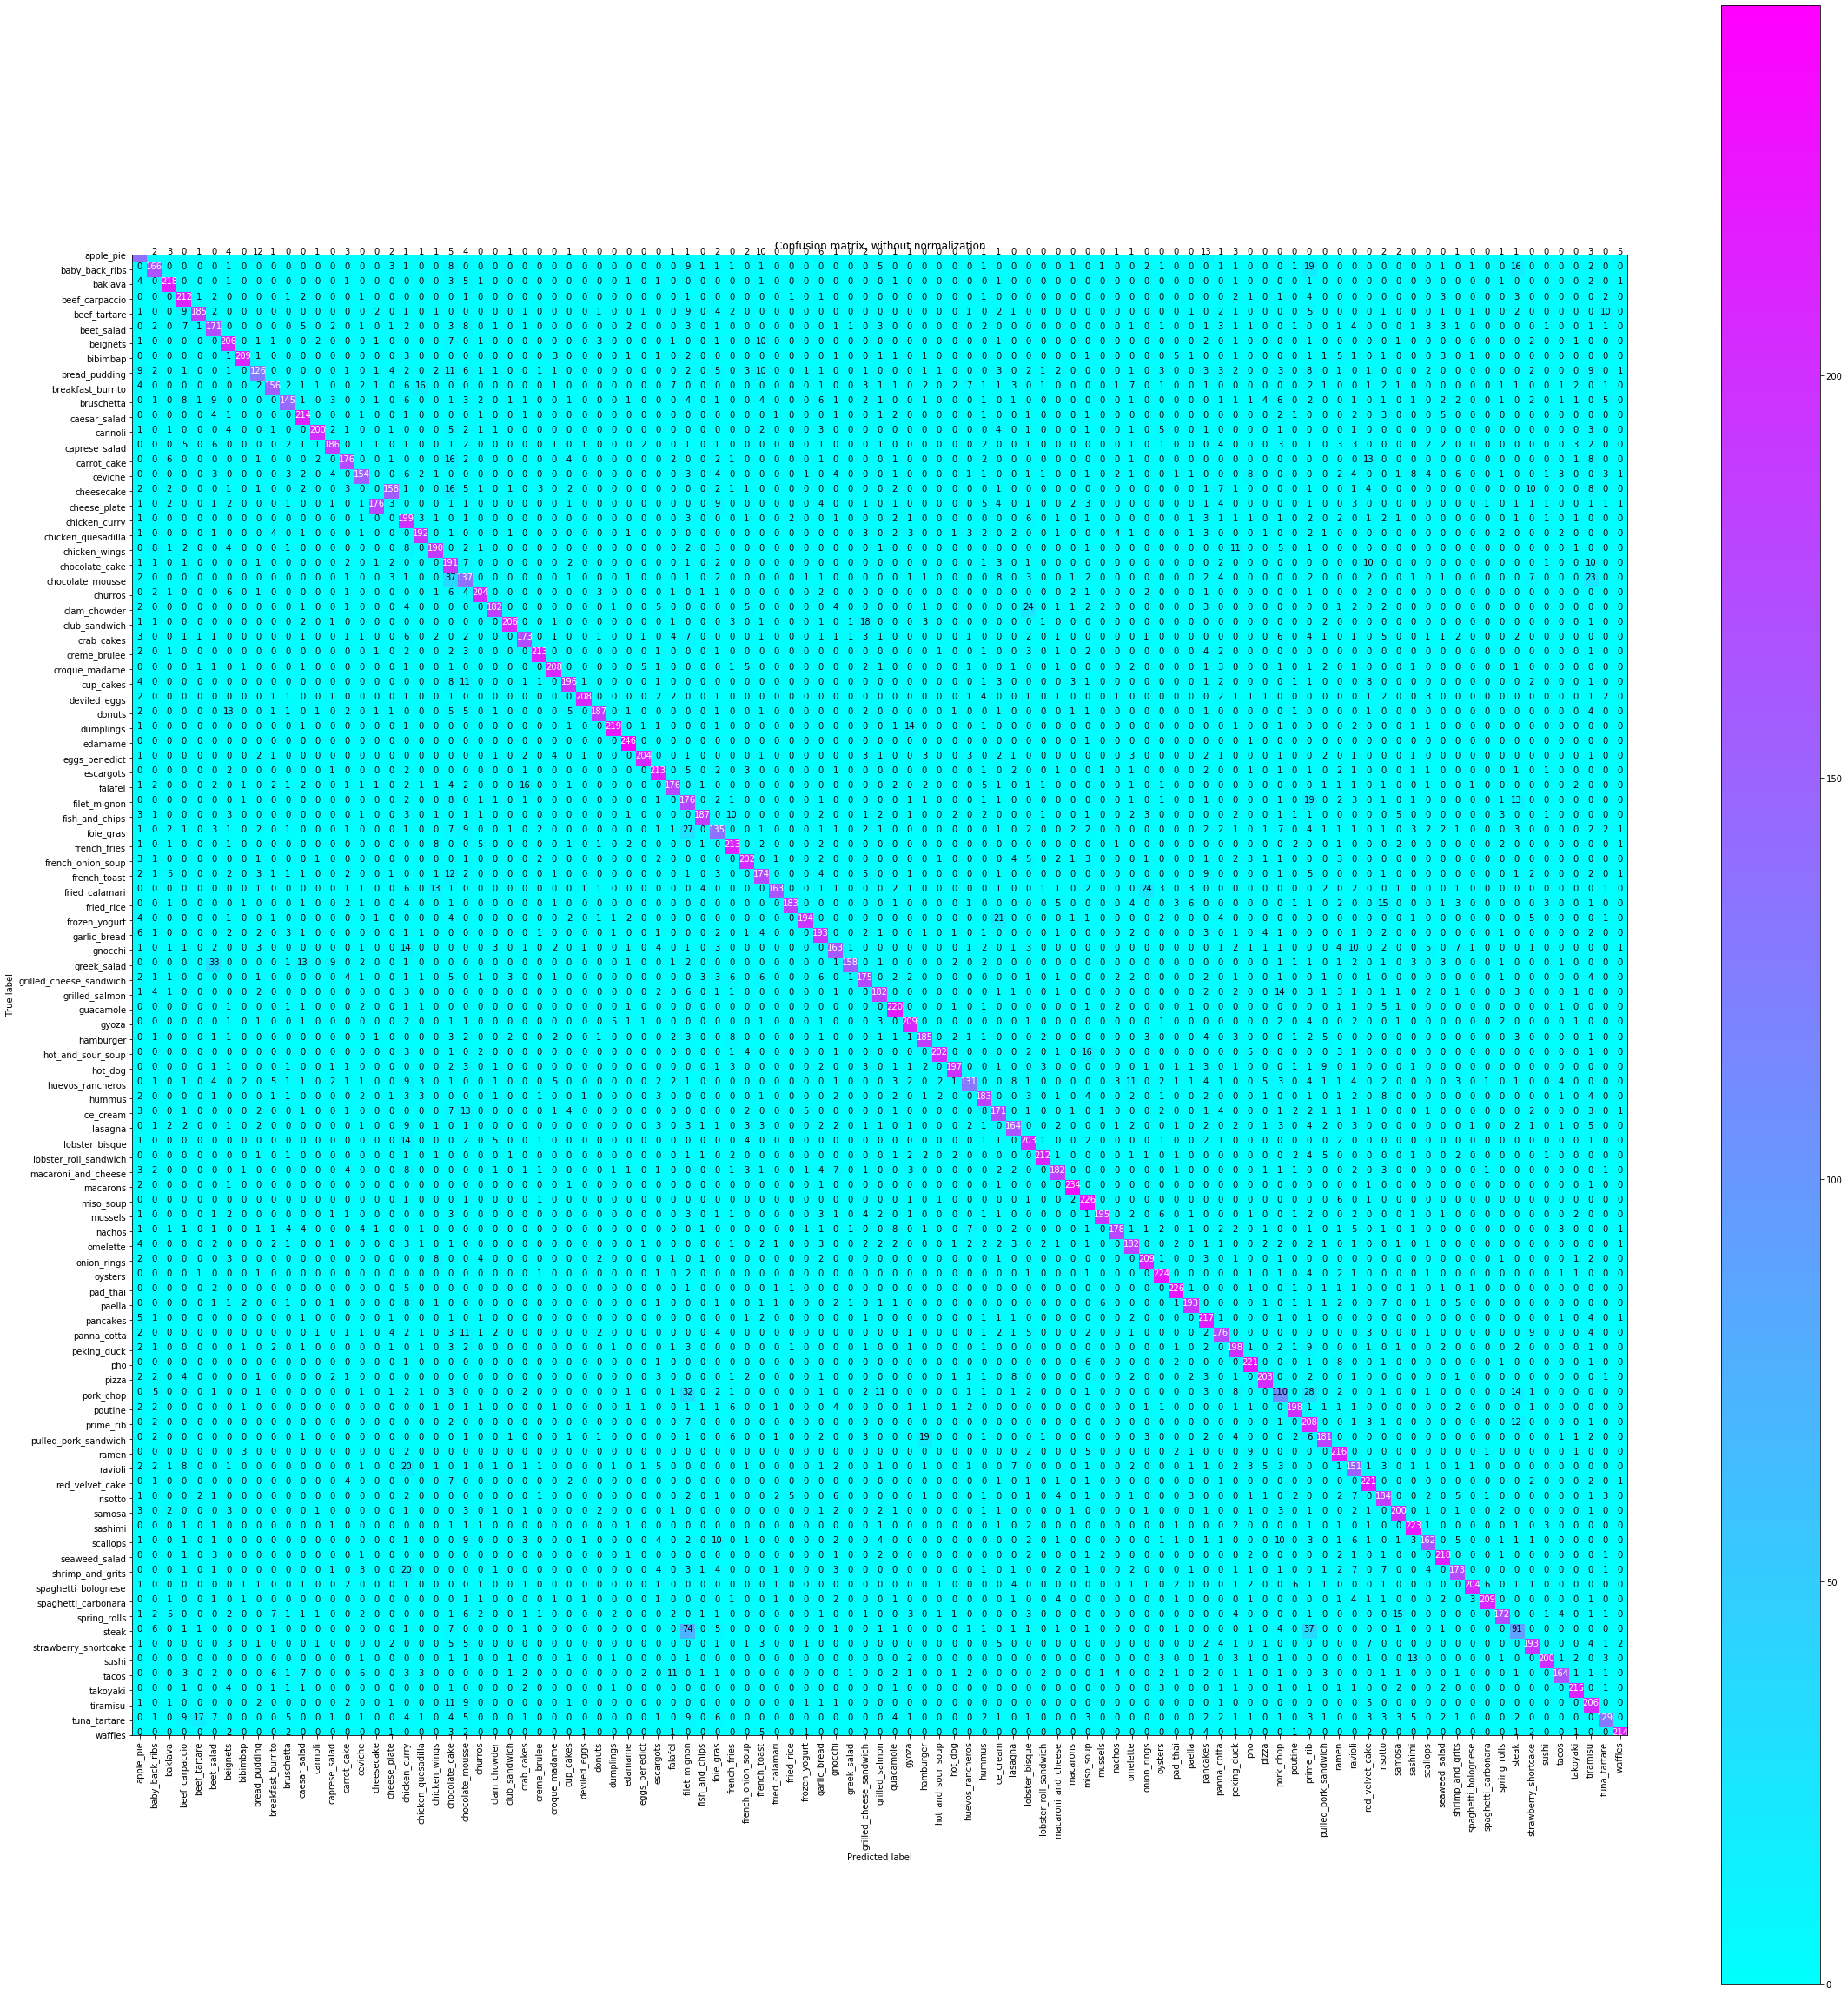

Wall time: 16.8 s


In [19]:
%%time
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

class_names = [ix_to_class[i] for i in range(101)]

plt.figure()
fig = plt.gcf()
fig.set_size_inches(32, 32)
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization',
                      cmap=plt.cm.cool)
plt.show()

Text(0.5, 1.0, 'Accuracy by Class histogram')

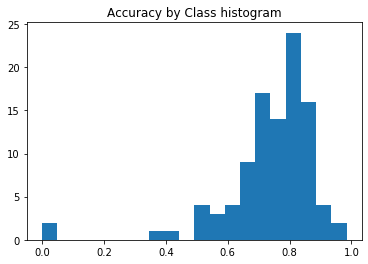

In [21]:
corrects = collections.defaultdict(int)
incorrects = collections.defaultdict(int)
for (pred, actual) in zip(y_pred, y_test):
    if pred == actual:
        corrects[actual] += 1
    else:
        incorrects[actual] += 1

class_accuracies = {}
for ix in range(101):
    class_accuracies[ix] = corrects[ix]/250

plt.hist(list(class_accuracies.values()), bins=20)
plt.title('Accuracy by Class histogram')

In [22]:
sorted_class_accuracies = sorted(class_accuracies.items(), key=lambda x: -x[1])
[(ix_to_class[c[0]], c[1]) for c in sorted_class_accuracies]

[('edamame', 0.984),
 ('macarons', 0.936),
 ('miso_soup', 0.904),
 ('pad_thai', 0.904),
 ('oysters', 0.896),
 ('sashimi', 0.892),
 ('pho', 0.884),
 ('red_velvet_cake', 0.884),
 ('guacamole', 0.88),
 ('dumplings', 0.876),
 ('baklava', 0.872),
 ('seaweed_salad', 0.872),
 ('pancakes', 0.868),
 ('ramen', 0.864),
 ('takoyaki', 0.86),
 ('caesar_salad', 0.856),
 ('waffles', 0.856),
 ('creme_brulee', 0.852),
 ('escargots', 0.852),
 ('french_fries', 0.852),
 ('beef_carpaccio', 0.848),
 ('lobster_roll_sandwich', 0.848),
 ('bibimbap', 0.836),
 ('gyoza', 0.836),
 ('onion_rings', 0.836),
 ('spaghetti_carbonara', 0.836),
 ('croque_madame', 0.832),
 ('deviled_eggs', 0.832),
 ('prime_rib', 0.832),
 ('beignets', 0.824),
 ('club_sandwich', 0.824),
 ('tiramisu', 0.824),
 ('churros', 0.816),
 ('eggs_benedict', 0.816),
 ('spaghetti_bolognese', 0.816),
 ('lobster_bisque', 0.812),
 ('pizza', 0.812),
 ('french_onion_soup', 0.808),
 ('hot_and_sour_soup', 0.808),
 ('cannoli', 0.8),
 ('samosa', 0.8),
 ('sushi', 